## Sentence Similarity

Word embeddings have become widespread in Natural Language Processing. They allow us to easily compute the semantic similarity between two words, or to find the words most similar to a target word. However, in many applications we're more interested in the similarity between two sentences or short texts. There are many ways to compare similarities of 2 texts using traditional methods like edit distance as well as using deep learning neural networks. In this notebook, I compare some simple ways of computing sentence similarity using word vectors and investigate how they perform.


### Loading Data
#### STS Benchmark
The STS Benchmark brings together the English data from the SemEval sentence similarity tasks between 2012 and 2017. The data is split in training, development and test data: http://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark

In [6]:
from preprocessing.load_data import download_and_load_sts_data, download_and_load_sick_dataset

sts_dev, sts_test = download_and_load_sts_data()
sts_test[:10]

,sent_1,sent_2,sim
0,A girl is styling her hair.,A girl is brushing her hair.,2.500
1,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,3.600
2,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,5.000
3,A man is cutting up a cucumber.,A man is slicing a cucumber.,4.200
4,A man is playing a harp.,A man is playing a keyboard.,1.500
5,A woman is cutting onions.,A woman is cutting tofu.,1.800
6,A man is riding an electric bicycle.,A man is riding a bicycle.,3.500
7,A man is playing the drums.,A man is playing the guitar.,2.200
8,A man is playing guitar.,A lady is playing the guitar.,2.200
9,A man is playing a guitar.,A man is playing a trumpet.,1.714


#### SICK data
The SICK dataset contains 10,000 English sentence pairs labelled with their semantic relatedness and entailment relation.

In [7]:
sick_all, sick_train, sick_test, sick_dev = download_and_load_sick_dataset()
sick_all[:10]

,idx,sent_1,sent_2,sim,label
0,1,A group of kids is playing in a yard and an ol...,A group of boys in a yard is playing and a man...,4.5,NEUTRAL
1,2,A group of children is playing in the house an...,A group of kids is playing in a yard and an ol...,3.2,NEUTRAL
2,3,The young boys are playing outdoors and the ma...,The kids are playing outdoors near a man with ...,4.7,ENTAILMENT
3,5,The kids are playing outdoors near a man with ...,A group of kids is playing in a yard and an ol...,3.4,NEUTRAL
4,9,The young boys are playing outdoors and the ma...,A group of kids is playing in a yard and an ol...,3.7,NEUTRAL
5,12,Two dogs are fighting,Two dogs are wrestling and hugging,4.0,NEUTRAL
6,14,A brown dog is attacking another animal in fro...,Two dogs are fighting,3.5,NEUTRAL
7,18,A brown dog is attacking another animal in fro...,Two dogs are wrestling and hugging,3.2,NEUTRAL
8,25,Nobody is riding the bicycle on one wheel,A person in a black jacket is doing tricks on ...,2.8,NEUTRAL
9,26,A person is riding the bicycle on one wheel,A man in a black jacket is doing tricks on a m...,3.7,NEUTRAL


### Loading Embeddings
2 word embeddings were used for this experiment. Word2vec and Glove. 

#### Loading word2vec

In [8]:
from embeddings.load_embeddings import load_word2vec
word2vec = load_word2vec("/data/word2vec/GoogleNews-vectors-negative300.bin.gz")

#### Loading Glove
To load Glove, we have to convert the downloaded GloVe file to word2vec format and then load the embeddings into a Gensim model. 

In [9]:
from embeddings.load_embeddings import load_glove
glove = load_glove("/data/glove/glove.840B.300d.txt")

#### Loading Frequencies
To weight the word vectors we need frequency stat. For that we used word frequencies that have been collected from Wikipedia. 

In [10]:
from utility.frequency_loader import load_frequencies, load_doc_frequencies

frequency = load_frequencies("/data/frequencies/frequencies.tsv")
doc_frequency = load_doc_frequencies("/data/frequencies/doc_frequencies.tsv")

### Vector Average
As our first similarity measure we are going to use vector average. Then take the embeddings of the words and calcluate the average to get a vector for the sentence. There are few benchmarks we created.
1. Calculating the average considering all the words. 
2. Calculating the average removing stop words.
3. Calculating the average while weighting the words with inverse document frequency.
4. Calculating the average while weighting the words with inverse document frequency and removing the stop words. 

These experiments were done using both word2vec and Glove. 

In [58]:
import functools as ft
from preprocessing.normalize import normalize
from matrices.avg_embeddings import run_avg_benchmark
from utility.run_experiment import run_experiment
import pandas as pd
import matplotlib.pyplot as plt


benchmarks = [("AVG-W2V", ft.partial(run_avg_benchmark, model=word2vec, use_stoplist=False)),
              ("AVG-W2V-STOP", ft.partial(run_avg_benchmark, model=word2vec, use_stoplist=True)),
              ("AVG-W2V-TFIDF", ft.partial(run_avg_benchmark, model=word2vec, use_stoplist=False, doc_freqs=doc_frequency)),
              ("AVG-W2V-TFIDF-STOP",ft.partial(run_avg_benchmark, model=word2vec, use_stoplist=True, doc_freqs=doc_frequency)),
              ("AVG-GLOVE", ft.partial(run_avg_benchmark, model=glove, use_stoplist=False)),
              ("AVG-GLOVE-STOP", ft.partial(run_avg_benchmark, model=glove, use_stoplist=True)),
              ("AVG-GLOVE-TFIDF", ft.partial(run_avg_benchmark, model=glove, use_stoplist=False, doc_freqs=doc_frequency)),
              ("AVG-GLOVE-TFIDF-STOP",ft.partial(run_avg_benchmark, model=glove, use_stoplist=True, doc_freqs=doc_frequency))]


Method was tested for SICK dataset. Only the training sample was used. Pearson Correlation and Spearman Correlation was used between the actual similarity and predicted similarity to evaluate the benchmark. 

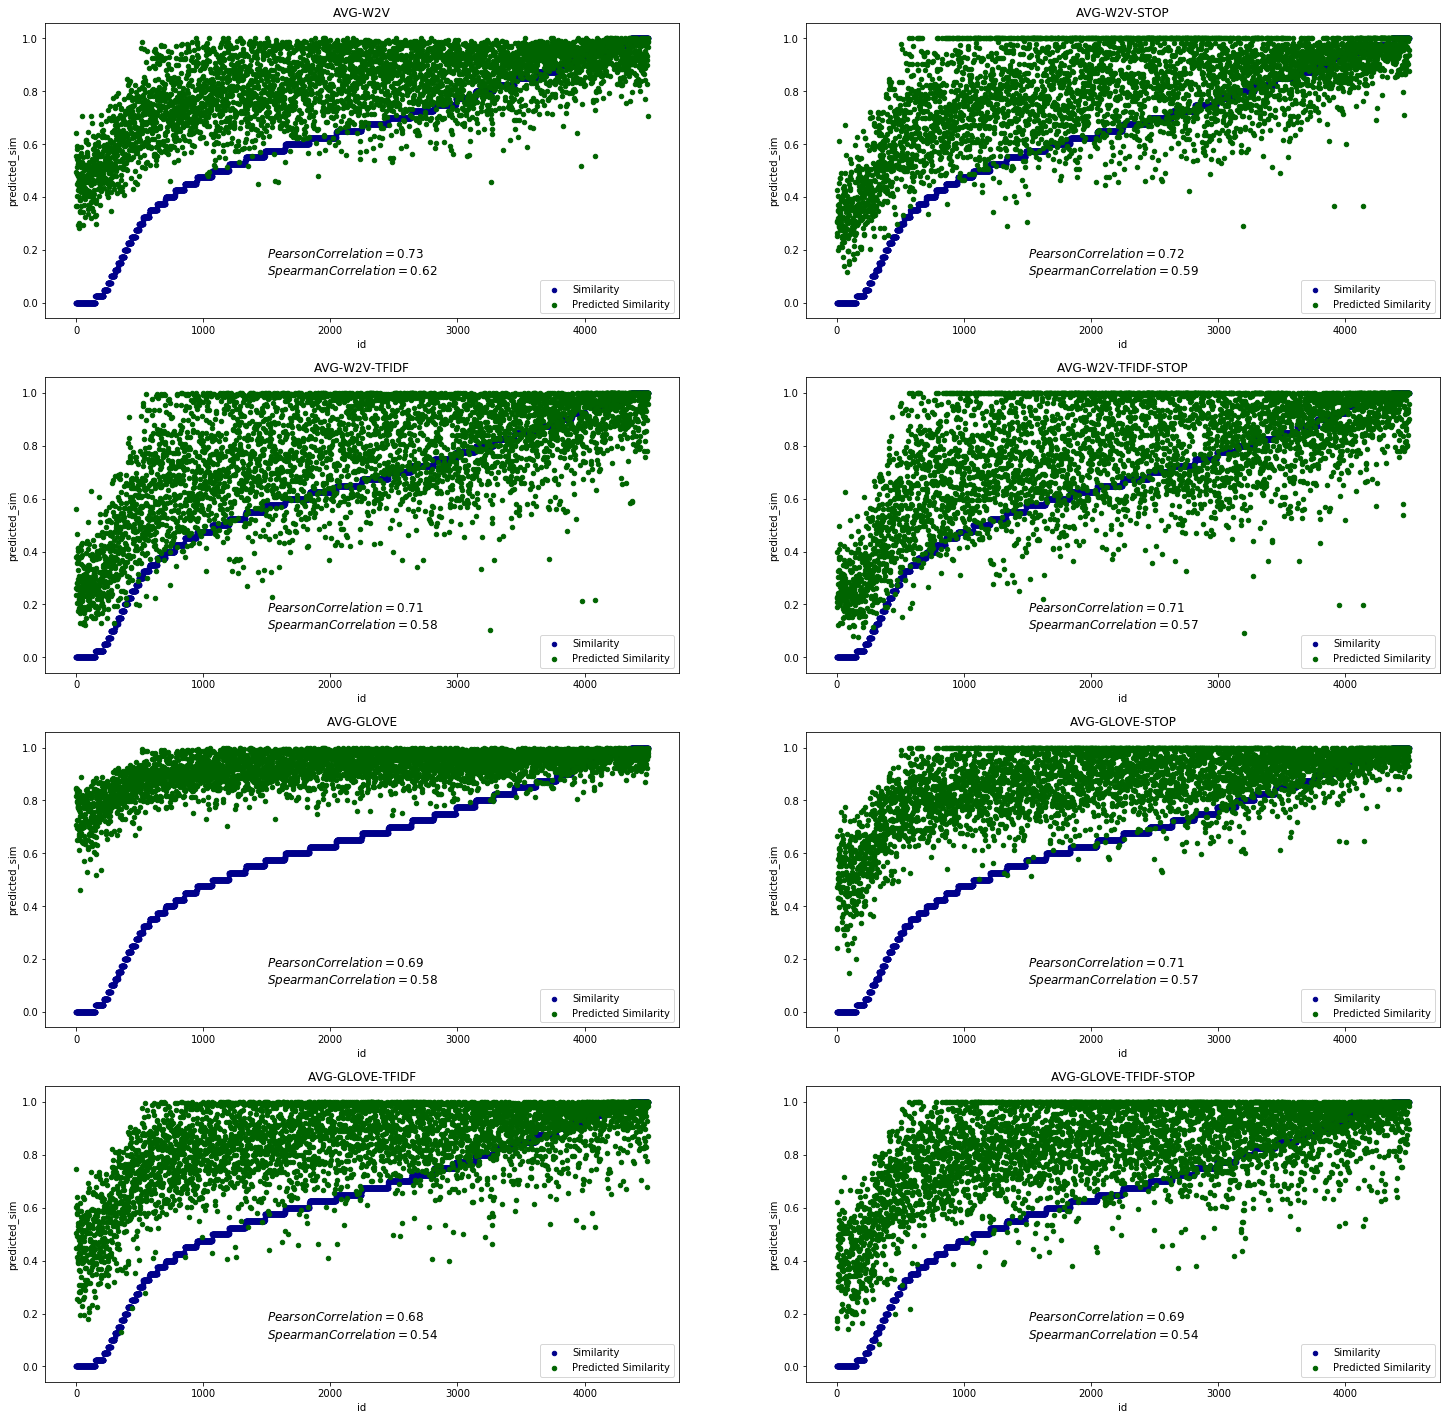

In [59]:
import scipy


fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(25,25))
row = 0
column = 0
sick_train = normalize(sick_train, ["sim"])
for i in range(0, 8):
    sims, topic = run_experiment(sick_train, benchmarks[i])
    pearson_correlation = scipy.stats.pearsonr(sims, sick_train['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sick_train['sim'])[0]
    textstr = '$Pearson Correlation=%.2f$\n$Spearman Correlation=%.2f$'%(pearson_correlation, spearman_correlation)
    sick_train['predicted_sim'] = pd.Series(sims).values
    sick_train = sick_train.sort_values('sim')
    id = list(range(0, len(sick_train.index)))
    sick_train['id'] = pd.Series(id).values
    
    if(i < 2):
        row = 0
        column = i
    if(i >= 2 and i < 4):
        row = 1
        column = i-2
    if(i >= 4 and i < 6):
        row = 2
        column = i-4
    if(i >=6 and i < 8):
        row = 3
        column = i-6
        
    sick_train.plot(kind='scatter', x='id', y='sim',color='DarkBlue', label='Similarity', title = topic, ax=axes[row, column]);
    sick_train.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity', ax=axes[row, column]);
    axes[row, column].text(1500, 0.1, textstr, fontsize=12)



The word2vec models tend to perform better than the Glove models. From word2vec models also taking the average without removing stop words and without using tf-idf gave the best performance to SICK dataset. Let's see the sentences that average word2vec model got totally differently. 

In [67]:
import math
import numpy as np

sims, topic = run_experiment(sick_train, benchmarks[0])
sick_train['predicted_sim'] = pd.Series(sims).values

sick_train["diff"] = np.sqrt((sick_train["predicted_sim"] - sick_train["sim"])**2)

sick_train = sick_train.sort_values("diff", ascending=False)
sick_train[:10]                                    

,idx,sent_1,sent_2,sim,label,predicted_sim,id,diff
2350,5251,Nobody is playing with a toad,A man is playing the trumpet,0.000,NEUTRAL,0.705554,149,0.705554
4404,9776,A boy wearing a striped shirt is running baref...,A woman is wearing a blue helmet and is riding...,0.000,NEUTRAL,0.705277,59,0.705277
2585,5737,A man is eating,A woman is sleeping,0.025,NEUTRAL,0.712331,183,0.687331
3860,8569,A black dog and a small white and black dog ar...,A black cat and a small white and black cat ar...,0.300,NEUTRAL,0.985079,510,0.685079
2568,5691,The person is playing with a skull,The man is playing the guitar,0.050,NEUTRAL,0.730141,223,0.680141
4493,9984,Two dogs are playing on the beach,Two people are driving a jeep and a lady is si...,0.000,NEUTRAL,0.678752,39,0.678752
2570,5694,The man is not playing the guitar,The man is playing with a skull,0.100,NEUTRAL,0.775704,296,0.675704
715,1626,The man is playing a piano,A guy is cheerfully playing with a footbag,0.075,NEUTRAL,0.745142,260,0.670142
266,631,The man is tossing a kid into the swimming poo...,A kid swimming in the ocean is tossing a coin ...,0.300,NEUTRAL,0.964954,504,0.664954
689,1573,A man is playing the guitar,A person is listening to a trumpet playing,0.125,NEUTRAL,0.781657,327,0.656657


In most of the sentences when the word order is difference it gives a high similarity score. And it certainly doesn't take the difference beween phrases like dog, cat and man woman even though it gives completely different meanings. 

Method was tested using STS data set. Only the dev sample was used. Pearson Correlation and Spearman Correlation was calcluated as before

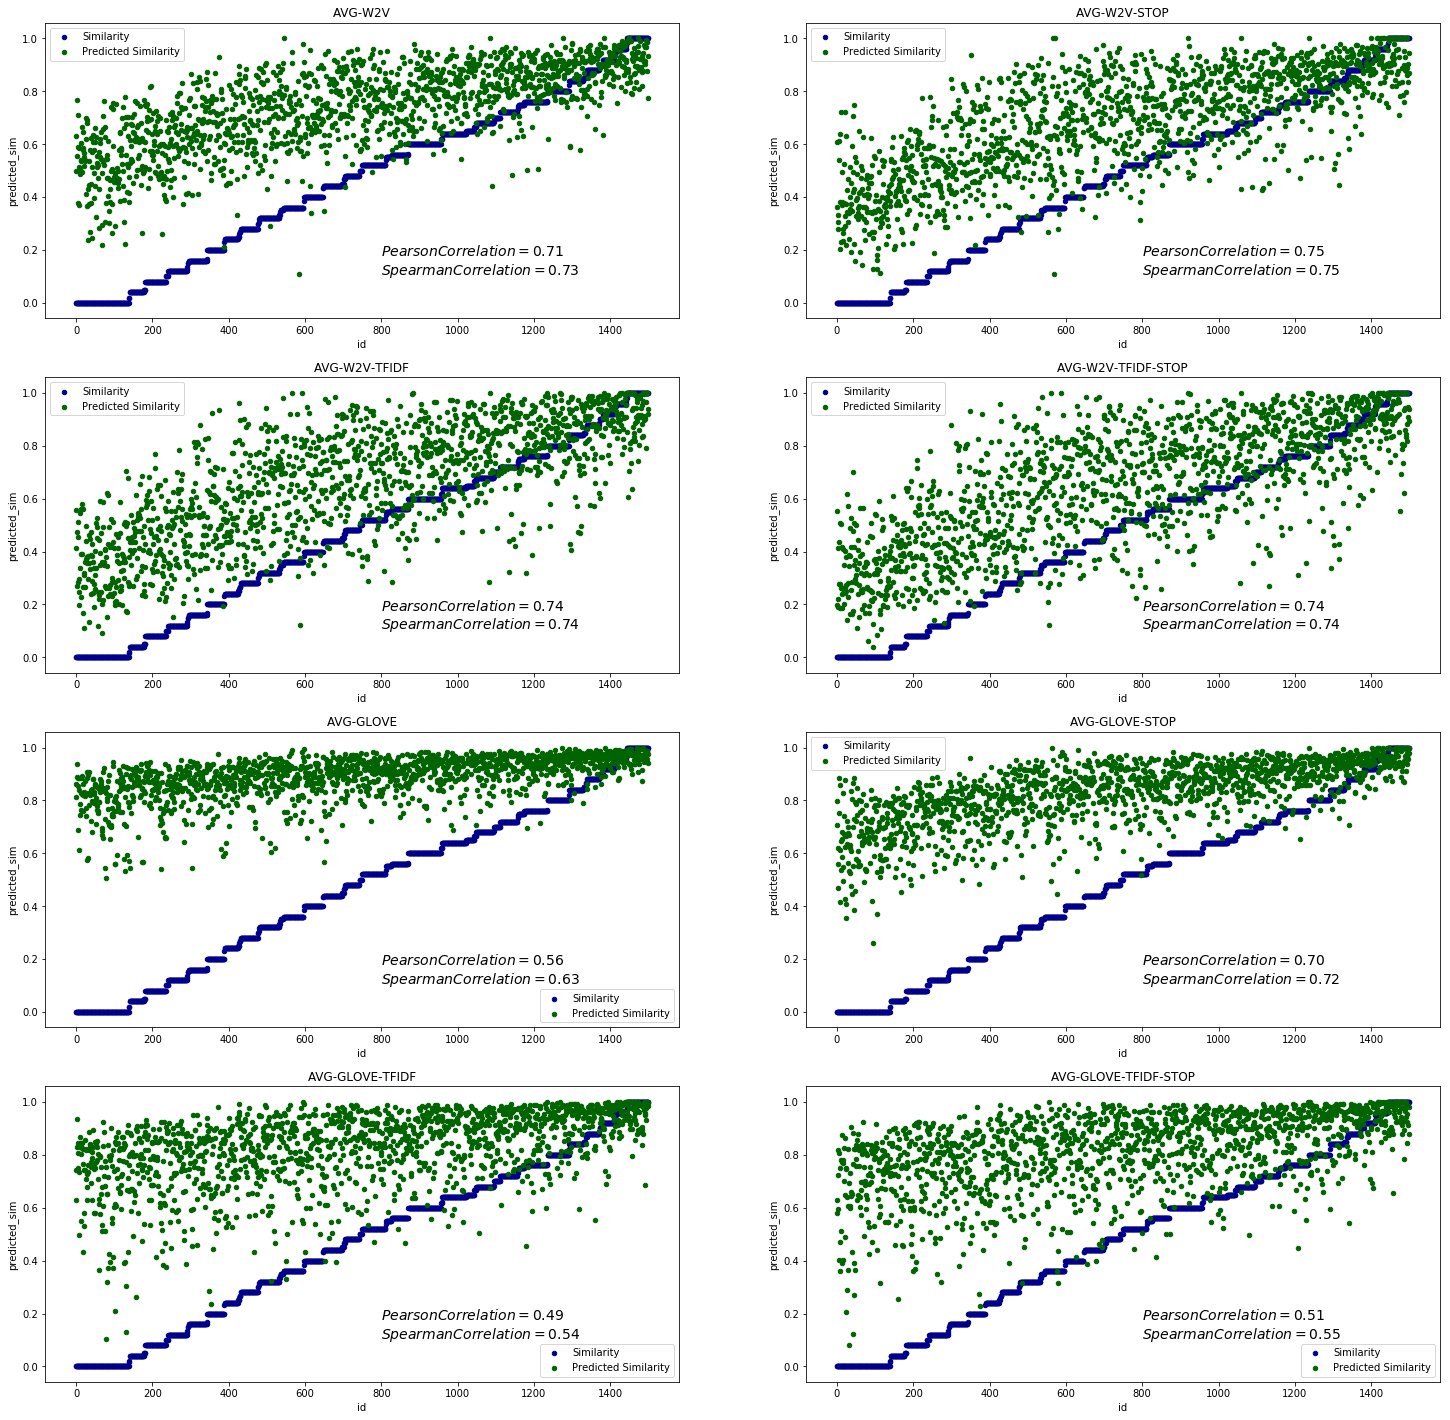

In [13]:
import scipy


fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(25,25))
row = 0
column = 0
sts_dev = normalize(sts_dev, ["sim"])
for i in range(0, 8):
    sims, topic = run_experiment(sts_dev, benchmarks[i])
    pearson_correlation = scipy.stats.pearsonr(sims, sts_dev['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sts_dev['sim'])[0]
    textstr = '$Pearson Correlation=%.2f$\n$Spearman Correlation=%.2f$'%(pearson_correlation, spearman_correlation)
    sts_dev['predicted_sim'] = pd.Series(sims).values
    sts_dev = sts_dev.sort_values('sim')
    id = list(range(0, len(sts_dev.index)))
    sts_dev['id'] = pd.Series(id).values
    
    if(i < 2):
        row = 0
        column = i
    if(i >= 2 and i < 4):
        row = 1
        column = i-2
    if(i >= 4 and i < 6):
        row = 2
        column = i-4
    if(i >=6 and i < 8):
        row = 3
        column = i-6
        
    sts_dev.plot(kind='scatter', x='id', y='sim',color='DarkBlue', label='Similarity', title = topic, ax=axes[row, column]);
    sts_dev.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity', ax=axes[row, column]);
    axes[row, column].text(800, 0.1, textstr, fontsize=14)



With STS Data set also Word2vec models perform better than Glove. Methods involving word2vec didn't have much difference in the corerelation in predictions and actual value, but from them 4th approach worked better this time. Let's consider the sentences it completely got wrong. 

In [68]:
import math
import numpy as np

sims, topic = run_experiment(sts_dev, benchmarks[3])
sts_dev['predicted_sim'] = pd.Series(sims).values

sts_dev["diff"] = np.sqrt((sts_dev["predicted_sim"] - sts_dev["sim"])**2)

sts_dev = sts_dev.sort_values("diff", ascending=False)
sts_dev[:10]    

,sent_1,sent_2,sim,predicted_sim,id,diff
533,There is a young girl.,There is a young boy with the woman.,0.20,0.932225,379,0.732225
1423,6.4-magnitude quake strikes off Indonesia,6.9-magnitude quake strikes off Russia's Kuril...,0.20,0.920009,378,0.720009
1398,"5 killed, 50 injured in Pakistan blast","3 killed, 138 injured in Boston blasts: media",0.16,0.877956,311,0.717956
465,A man wearing US flag boxer shorts is standing...,A woman wearing a white shirt stands on the st...,0.00,0.702269,66,0.702269
155,Three men are dancing.,Women are dancing.,0.26,0.960167,428,0.700167
803,I would recommend asking questions in a way th...,Would you be concerned with the mind changing ...,0.08,0.744766,218,0.664766
1254,Saudi gas truck blast kills at least 22,Nigeria church blast kills at least 12,0.12,0.781738,250,0.661738
936,I don't think we have a solid theory of mammal...,The short answer is that evolution couldn't cr...,0.16,0.810511,299,0.650511
612,The child is the woman's kid.,There is a boy and a girl.,0.16,0.806808,316,0.646808
492,A skateboarder jumps off the stairs.,A dog jumps off the stairs.,0.16,0.805102,324,0.645102


The errors we discussed in the previous section appears here also. 

### Word Mover's Distance
Word mover's distance is a popular alternative to the simple average embedding similarity. The Word Mover's Distance uses the word embeddings of the words in two texts to measure the minimum amount that the words in one text need to "travel" in semantic space to reach the words of the other text. 

In [14]:
from matrices.word_movers_distance import run_wmd_benchmark

benchmarks = [("WMD-W2V", ft.partial(run_wmd_benchmark, model=word2vec, use_stoplist=False)), 
              ("WMD-W2V-STOP", ft.partial(run_wmd_benchmark, model=word2vec, use_stoplist=True)), 
              ("WMD-GLOVE", ft.partial(run_wmd_benchmark, model=glove, use_stoplist=False)), 
              ("WMD-GLOVE-STOP", ft.partial(run_wmd_benchmark, model=glove, use_stoplist=True)) ]

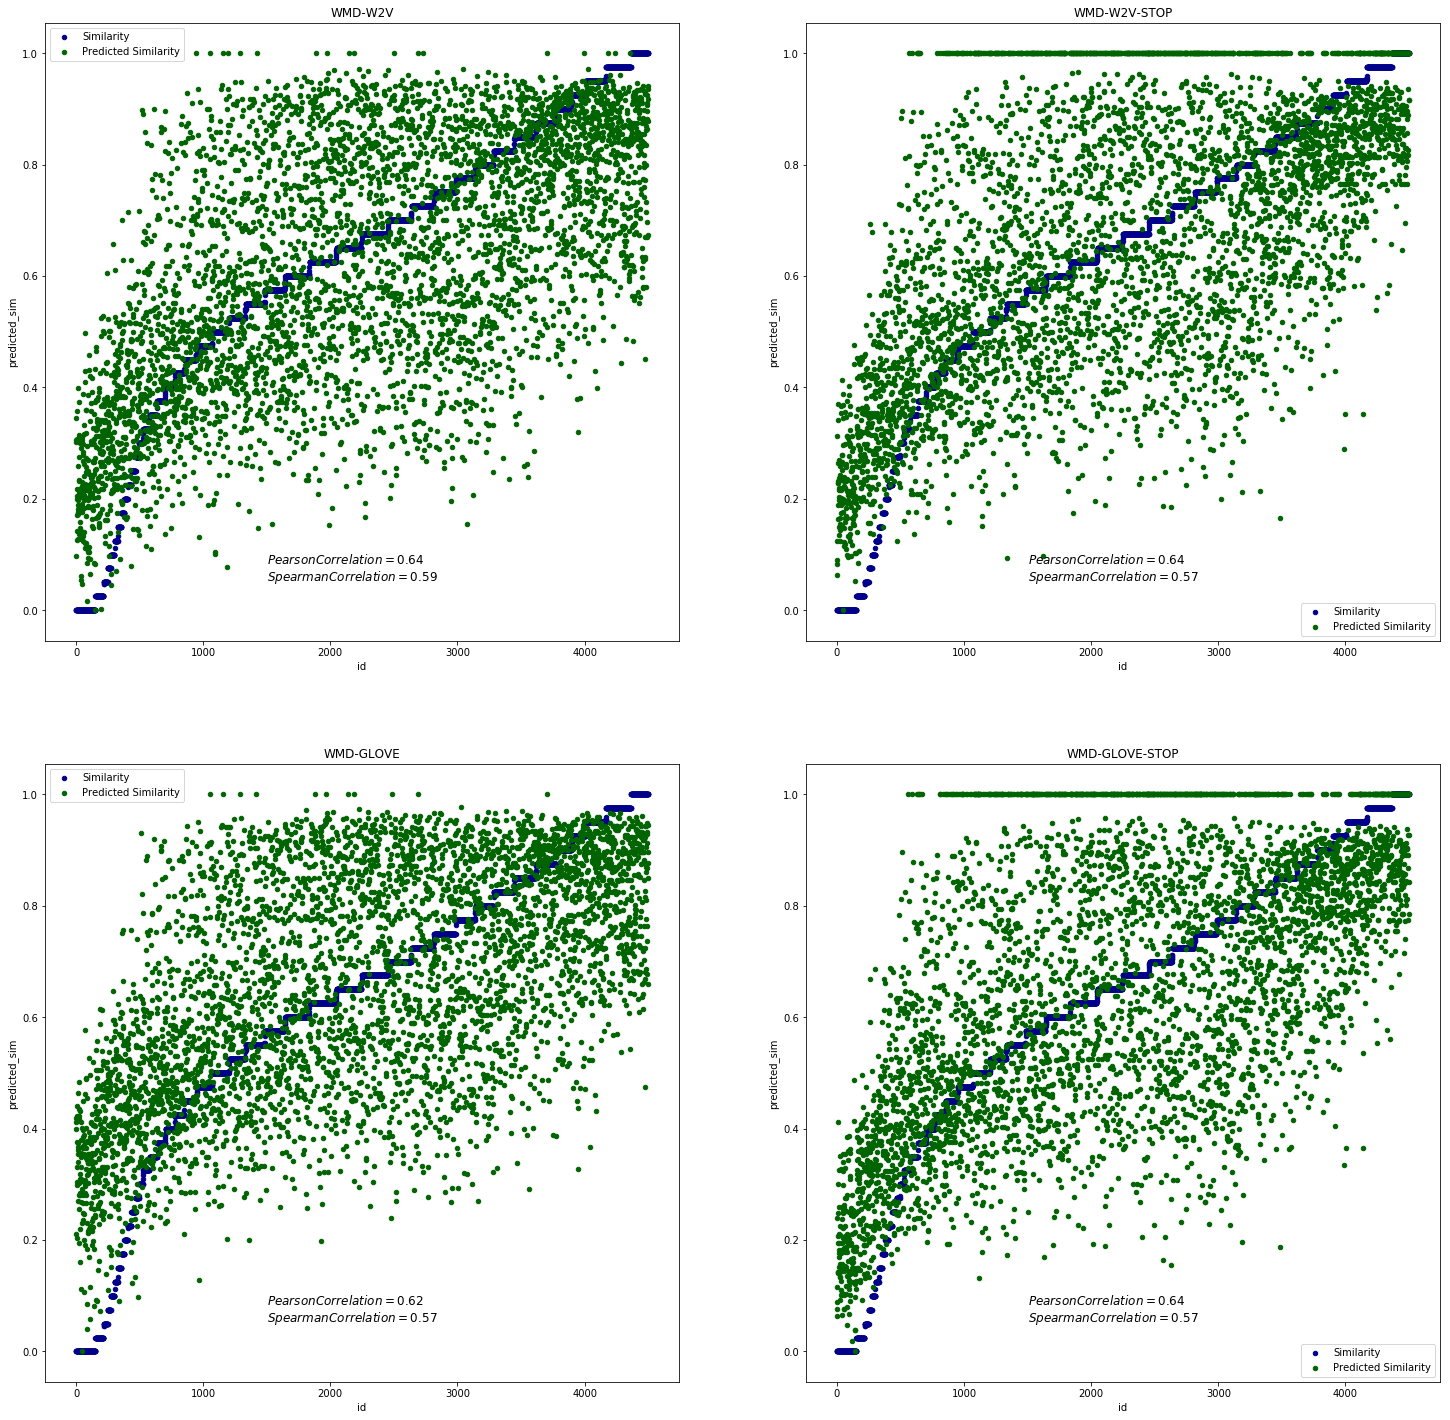

In [15]:
import scipy


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(25,25))
row = 0
column = 0
sick_train = normalize(sick_train, ["sim"])
for i in range(0, 4):
    sims, topic = run_experiment(sick_train, benchmarks[i])
    pearson_correlation = scipy.stats.pearsonr(sims, sick_train['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sick_train['sim'])[0]
    textstr = '$Pearson Correlation=%.2f$\n$Spearman Correlation=%.2f$'%(pearson_correlation, spearman_correlation)
    sick_train['predicted_sim'] = pd.Series(sims).values
    sick_train = normalize(sick_train, ["predicted_sim"])
    sick_train = sick_train.sort_values('sim')
    id = list(range(0, len(sick_train.index)))
    sick_train['id'] = pd.Series(id).values
    
    if(i < 2):
        row = 0
        column = i
    if(i >= 2 and i < 4):
        row = 1
        column = i-2
        
    sick_train.plot(kind='scatter', x='id', y='sim',color='DarkBlue', label='Similarity', title = topic, ax=axes[row, column]);
    sick_train.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity', ax=axes[row, column]);
    axes[row, column].text(1500, 0.05, textstr, fontsize=12)



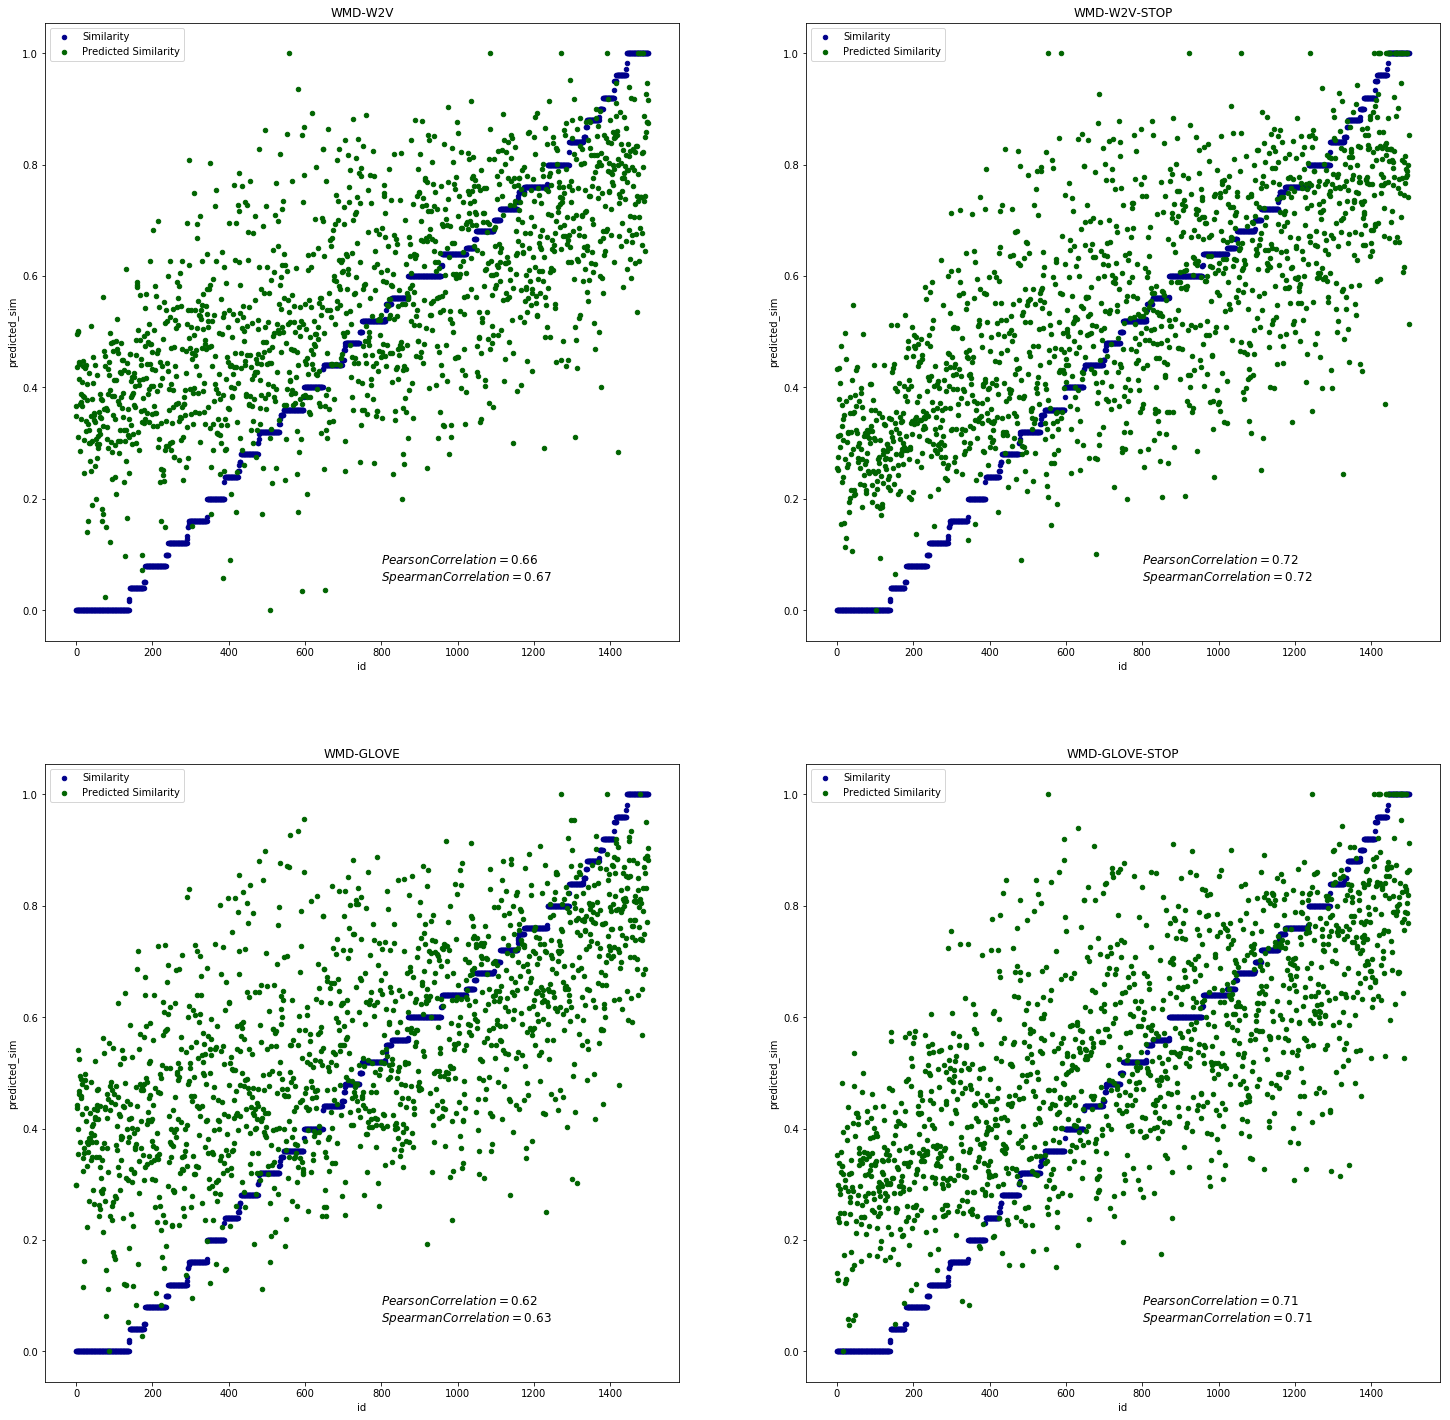

In [16]:

import scipy


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(25,25))
row = 0
column = 0
sts_dev = normalize(sts_dev, ["sim"])
for i in range(0, 4):
    sims, topic = run_experiment(sts_dev, benchmarks[i])
    pearson_correlation = scipy.stats.pearsonr(sims, sts_dev['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sts_dev['sim'])[0]
    textstr = '$Pearson Correlation=%.2f$\n$Spearman Correlation=%.2f$'%(pearson_correlation, spearman_correlation)
    sts_dev['predicted_sim'] = pd.Series(sims).values
    sts_dev = normalize(sts_dev, ["predicted_sim"])
    sts_dev = sts_dev.sort_values('sim')
    id = list(range(0, len(sts_dev.index)))
    sts_dev['id'] = pd.Series(id).values
    
    if(i < 2):
        row = 0
        column = i
    if(i >= 2 and i < 4):
        row = 1
        column = i-2
        
    sts_dev.plot(kind='scatter', x='id', y='sim',color='DarkBlue', label='Similarity', title = topic, ax=axes[row, column]);
    sts_dev.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity', ax=axes[row, column]);
    axes[row, column].text(800, 0.05, textstr, fontsize=12)

### Smooth Inverse Frequency
Taking the average of the word embeddings in a sentence, like we did above, is a very crude method of computing sentence embeddings. Most importantly, this gives far too much weight to words that are quite irrelevant, semantically speaking. Smooth Inverse Frequency tries to solve this problem.

To compute SIF sentence embeddings, we first compute a weighted average of the token embeddings in the sentence. This procedure is very similar to the weighted average we used above, with the single difference that the word embeddings are weighted by a/a+p(w), where w is a parameter that is set to 0.001 by default, and p(w) is the estimated relative frequency of a word in a reference corpus.

Next, we need to perform common component removal: we compute the principal component of the sentence embeddings we obtained above and subtract from them their projections on this first principal component. This corrects for the influence of high-frequency words that mostly have a syntactic or discourse function, such as "just", "there", "but", etc.

In [19]:
from matrices.smooth_inverse_frequency import run_sif_benchmark


benchmarks = [("SIF-W2V", ft.partial(run_sif_benchmark, freqs=frequency, model=word2vec, use_stoplist=False)),
              ("SIF-GLOVE", ft.partial(run_sif_benchmark, freqs=frequency, model=glove, use_stoplist=False))]

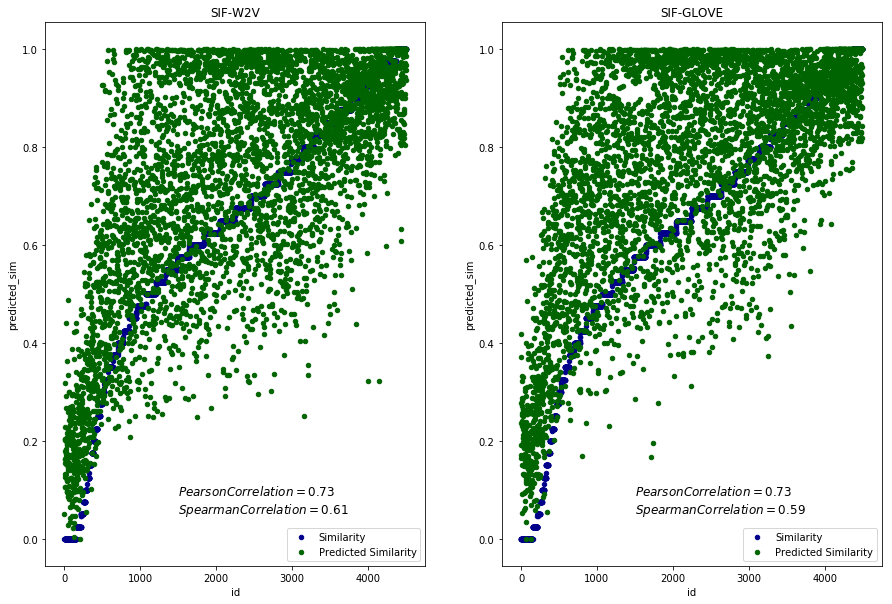

In [21]:
import scipy


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
row = 0
column = 0
sick_train = normalize(sick_train, ["sim"])
for i in range(0, 2):
    sims, topic = run_experiment(sick_train, benchmarks[i])
    pearson_correlation = scipy.stats.pearsonr(sims, sick_train['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sick_train['sim'])[0]
    textstr = '$Pearson Correlation=%.2f$\n$Spearman Correlation=%.2f$'%(pearson_correlation, spearman_correlation)
    sick_train['predicted_sim'] = pd.Series(sims).values
    sick_train = normalize(sick_train, ["predicted_sim"])
    sick_train = sick_train.sort_values('sim')
    id = list(range(0, len(sick_train.index)))
    sick_train['id'] = pd.Series(id).values
    
    if(i < 2):
        column = i
        
    sick_train.plot(kind='scatter', x='id', y='sim',color='DarkBlue', label='Similarity', title = topic, ax=axes[column]);
    sick_train.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity', ax=axes[column]);
    axes[column].text(1500, 0.05, textstr, fontsize=12)

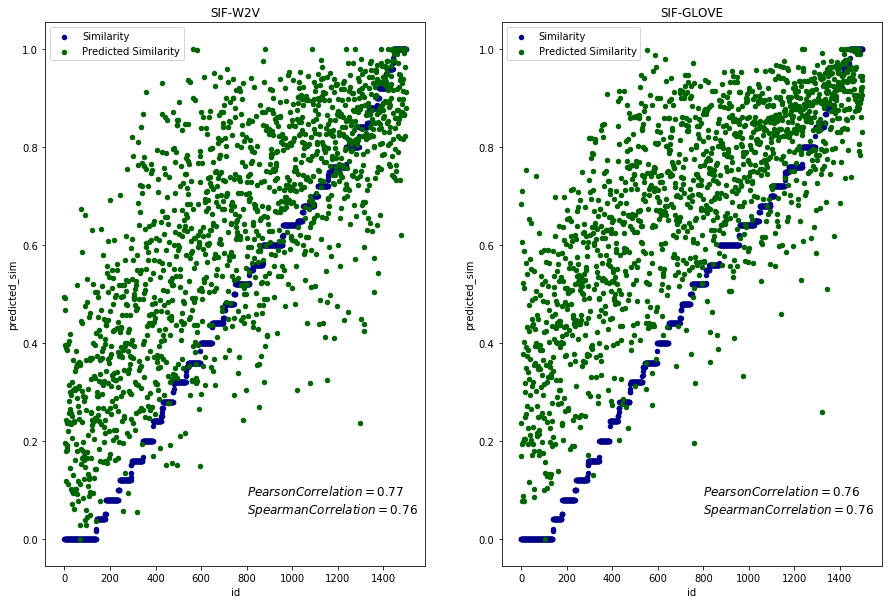

In [22]:
import scipy


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
row = 0
column = 0
sts_dev = normalize(sts_dev, ["sim"])
for i in range(0, 2):
    sims, topic = run_experiment(sts_dev, benchmarks[i])
    pearson_correlation = scipy.stats.pearsonr(sims, sts_dev['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sts_dev['sim'])[0]
    textstr = '$Pearson Correlation=%.2f$\n$Spearman Correlation=%.2f$'%(pearson_correlation, spearman_correlation)
    sts_dev['predicted_sim'] = pd.Series(sims).values
    sts_dev = normalize(sts_dev, ["predicted_sim"])
    sts_dev = sts_dev.sort_values('sim')
    id = list(range(0, len(sts_dev.index)))
    sts_dev['id'] = pd.Series(id).values
    
    if(i < 2):
        column = i
        
    sts_dev.plot(kind='scatter', x='id', y='sim',color='DarkBlue', label='Similarity', title = topic, ax=axes[column]);
    sts_dev.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity', ax=axes[column]);
    axes[column].text(800, 0.05, textstr, fontsize=12)

### InferSent
InferSent is a pre-trained encoder that produces sentence embeddings. More particularly, it is a BiLSTM with max pooling that was trained on the SNLI dataset, 570k English sentence pairs labelled with one of three categories: entailment, contradiction or neutral. InferSent was developed and trained by Facebook Research.

In [23]:
import torch
from utility.infer_sent.models import InferSent


MODEL_PATH = "/data/InferSent/encoder/infersent1.pkl"
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': 1}
model = InferSent(params_model)
model.load_state_dict(torch.load(MODEL_PATH))
GLOVE_PATH = '/data/glove/glove.840B.300d.txt'
model.set_w2v_path(GLOVE_PATH)

In [24]:
import tensorflow_hub as hub

embed = hub.Module("https://tfhub.dev/google/universal-sentence-encoder/2")

In [55]:
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf

def run_gse_benchmark(sentences1, sentences2, embed):
    sts_input1 = tf.placeholder(tf.string, shape=(None))
    sts_input2 = tf.placeholder(tf.string, shape=(None))

    sts_encode1 = tf.nn.l2_normalize(tf.map_fn(embed(sts_input1)), axis=1)
    sts_encode2 = tf.nn.l2_normalize(tf.map_fn(embed(sts_input2)), axis=1)
        
    sim_scores = tf.reduce_sum(tf.multiply(sts_encode1, sts_encode2), axis=1)
    
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        session.run(tf.tables_initializer())
      
        [gse_sims] = session.run(
            [sim_scores],
            feed_dict={
                sts_input1: [sent1.raw for sent1 in sentences1],
                sts_input2: [sent2.raw for sent2 in sentences2]
            })

    return gse_sims




In [56]:
from matrices.infer_sent import run_inf_benchmark
import functools as ft

benchmarks = [ ("INF", ft.partial(run_inf_benchmark, infersent=model)), 
             ("GSE", ft.partial(run_gse_benchmark, embed=model))]


Found 2253(/2257) words with w2v vectors
Vocab size : 2253


TypeError: Tensor objects are only iterable when eager execution is enabled. To iterate over this tensor use tf.map_fn.

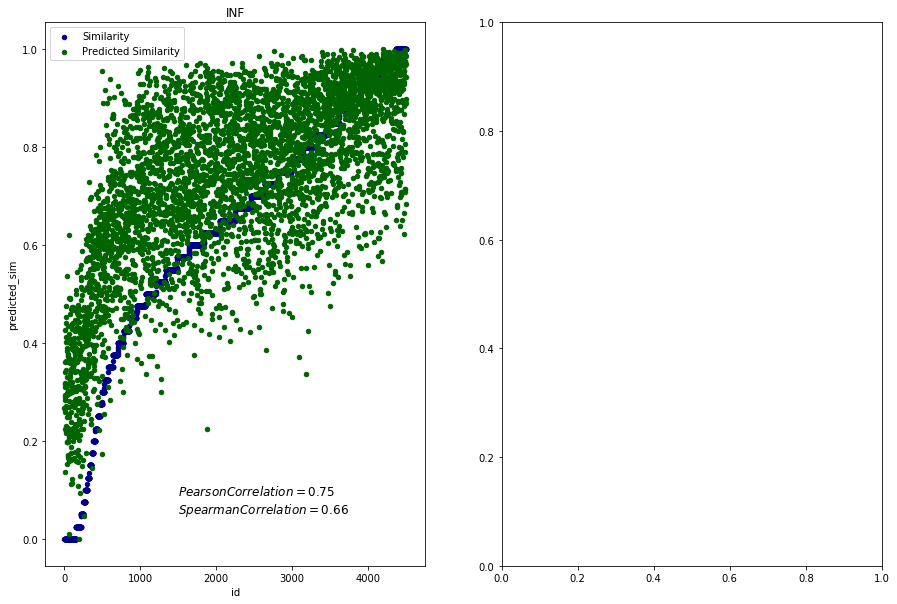

In [57]:
import scipy


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
row = 0
column = 0
sick_train = normalize(sick_train, ["sim"])
for i in range(0, 2):
    sims, topic = run_experiment(sick_train, benchmarks[i])
    pearson_correlation = scipy.stats.pearsonr(sims, sick_train['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sick_train['sim'])[0]
    textstr = '$Pearson Correlation=%.2f$\n$Spearman Correlation=%.2f$'%(pearson_correlation, spearman_correlation)
    sick_train['predicted_sim'] = pd.Series(sims).values
    sick_train = normalize(sick_train, ["predicted_sim"])
    sick_train = sick_train.sort_values('sim')
    id = list(range(0, len(sick_train.index)))
    sick_train['id'] = pd.Series(id).values
    
    if(i < 2):
        row = 0
        column = i
    
        
    sick_train.plot(kind='scatter', x='id', y='sim',color='DarkBlue', label='Similarity', title = topic, ax=axes[column]);
    sick_train.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity', ax=axes[column]);
    axes[row].text(1500, 0.05, textstr, fontsize=12)

